In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm

In [4]:
DATADIR = "/content/drive/My Drive/data" # "./data"
transactions_path = f"{DATADIR}/avk_hackathon_data_transactions.csv"

In [5]:
data = pd.read_csv(f"{DATADIR}/avk_hackathon_data_account_x_balance.csv")

In [6]:
data.head()

,party_rk,account_rk,prev_month,cur_month,balance_chng
0,51607,55309,2018-12-31,2019-01-31,15000.0
1,59074,70471,2018-12-31,2019-01-31,0.0
2,33941,33065,2018-12-31,2019-01-31,-15000.0
3,9336,8611,2018-12-31,2019-01-31,-50000.0
4,13958,8421,2018-12-31,2019-01-31,-20000.0


Here only clients with >1 year transaction history are used. It can be changed.



In [7]:
 data.groupby('account_rk').cur_month.count().max()

24

In [9]:
accs_long_hist = data.groupby('account_rk').cur_month.count().keys()[data.groupby('account_rk').cur_month.count().max() >= 12][0]

To to restore the lower bound of the account balance:
1. sort dates by account
2. apply cumsum
3. shift cumsum values by a constant so that they were >=0 (as balance can't be < 0 on debit card)



In [11]:
#sort dates
data_long_hist = data.loc[data['account_rk'].isin(accs_long_hist)].sort_values(['account_rk', 'cur_month'])

In [12]:
#apply cumsum
data_long_hist['cumsum'] = data_long_hist.groupby('account_rk')['balance_chng'].transform(pd.Series.cumsum)

In [13]:
#find minimum value of cumsum
data_long_hist['min'] = data_long_hist.groupby('account_rk')['cumsum'].transform('min')

In [14]:
#shift values if balance was < 0
data_long_hist['cumsum_shift'] = data_long_hist['cumsum'] - (data_long_hist['min'] < 0) * data_long_hist['min']

In [16]:
data_long_hist.head(12)

,party_rk,account_rk,prev_month,cur_month,balance_chng,cumsum,min,cumsum_shift
503392,71,1,2018-12-31,2019-01-31,-20000.0,-20000.0,-20000.0,0.0
11469,71,1,2019-01-31,2019-02-28,265000.0,245000.0,-20000.0,265000.0
499698,71,1,2019-02-28,2019-03-31,-160000.0,85000.0,-20000.0,105000.0
147932,71,1,2019-03-31,2019-04-30,-70000.0,15000.0,-20000.0,35000.0
297568,71,1,2019-04-30,2019-05-31,-25000.0,-10000.0,-20000.0,10000.0
75264,71,1,2019-05-31,2019-06-30,-5000.0,-15000.0,-20000.0,5000.0
310823,71,1,2019-06-30,2019-07-31,0.0,-15000.0,-20000.0,5000.0
273860,71,1,2019-07-31,2019-08-31,10000.0,-5000.0,-20000.0,15000.0
394514,71,1,2019-08-31,2019-09-30,-10000.0,-15000.0,-20000.0,5000.0
457305,71,1,2019-09-30,2019-10-31,0.0,-15000.0,-20000.0,5000.0


To find the guaranteed remaining sum of money we find minimum of balance lower bound. However, other metrics can be used, e.g. percentil.

In [17]:
#find guaranteed remaining sum 
min_remain = data_long_hist.groupby('account_rk').cumsum_shift.min()

We can now analyse the distribution of guaranteed remaining sums.

In [18]:
import matplotlib.pyplot as plt

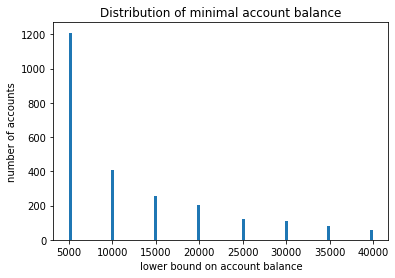

In [20]:
plt.hist(min_remain[(min_remain <= 40000) & (min_remain > 0)], bins=100)
plt.xlabel('lower bound on account balance')
plt.ylabel('number of accounts') 
plt.title('Distribution of minimal account balance')
plt.savefig(f"{DATADIR}/balance.png")

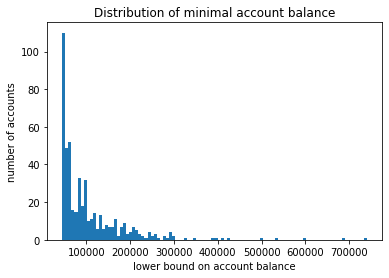

In [21]:
plt.hist(min_remain[(min_remain > 40000)], bins=100)
plt.xlabel('lower bound on account balance')
plt.ylabel('number of accounts') 
plt.title('Distribution of minimal account balance')
plt.savefig(f"{DATADIR}/balance_tail.png") 